<a href="https://colab.research.google.com/github/athabrani/DeepLearning/blob/main/DeteksiSarkasme_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk

import nltk
import pandas as pd
import numpy as np
import json
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\athallah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\athallah\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json"
df = pd.read_json(url, lines=True)

In [ ]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
print("Jumlah data: ", len(df))

Jumlah data:  26709


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

# Parameters
num_words = 10000
maxlen = 100
embedding_dim = 256
hidden_dim = 512
output_dim = 1
n_layers = 2
dropout = 0.5
batch_size = 64
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def build_vocab(texts, max_words):
    word_counts = {}
    for text in texts:
        for word in text.split():
            word_counts[word] = word_counts.get(word, 0) + 1
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for i, (word, _) in enumerate(sorted_words[:max_words-2]):
        vocab[word] = i + 2
    return vocab

def to_sequence(text, vocab, maxlen):
    sequence = [vocab.get(w, vocab['<UNK>']) for w in text.split()]
    return sequence[:maxlen] + [vocab['<PAD>']] * (maxlen - len(sequence))


df['processed'] = df['headline'].apply(preprocess_text)
vocab = build_vocab(df['processed'], num_words)
df['seq'] = df['processed'].apply(lambda x: to_sequence(x, vocab, maxlen))

X = np.array(df['seq'].tolist())
y = np.array(df['is_sarcastic'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class SarcasmDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_loader = DataLoader(SarcasmDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(SarcasmDataset(X_test, y_test), batch_size=batch_size)


#RNN Model

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, output_dim=1, n_layers=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers,
                          dropout=dropout, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(self.dropout(hidden_cat)).squeeze(1)


In [ ]:
def train_model(model, train_loader, test_loader, epochs=10, lr=0.0005):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (torch.sigmoid(output) >= 0.5).float()
            total_correct += (preds == y_batch).sum().item()

        acc = total_correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f} - Accuracy: {acc:.4f}")

rnn_model = RNNModel(vocab_size=len(vocab))
train_model(rnn_model, train_loader, test_loader)


Epoch 1/10 - Loss: 214.4419 - Accuracy: 0.6259
Epoch 2/10 - Loss: 198.3227 - Accuracy: 0.6745
Epoch 3/10 - Loss: 177.9956 - Accuracy: 0.7284
Epoch 4/10 - Loss: 154.5064 - Accuracy: 0.7820
Epoch 5/10 - Loss: 134.6542 - Accuracy: 0.8176
Epoch 6/10 - Loss: 116.9253 - Accuracy: 0.8473
Epoch 7/10 - Loss: 104.6148 - Accuracy: 0.8692
Epoch 8/10 - Loss: 90.2257 - Accuracy: 0.8914
Epoch 9/10 - Loss: 79.6105 - Accuracy: 0.9074
Epoch 10/10 - Loss: 73.9585 - Accuracy: 0.9163



RNN Final Evaluation on Test Set:
Accuracy : 0.5331
Precision: 0.4610
Recall   : 0.3725
F1 Score : 0.4121
AUC      : 0.5226


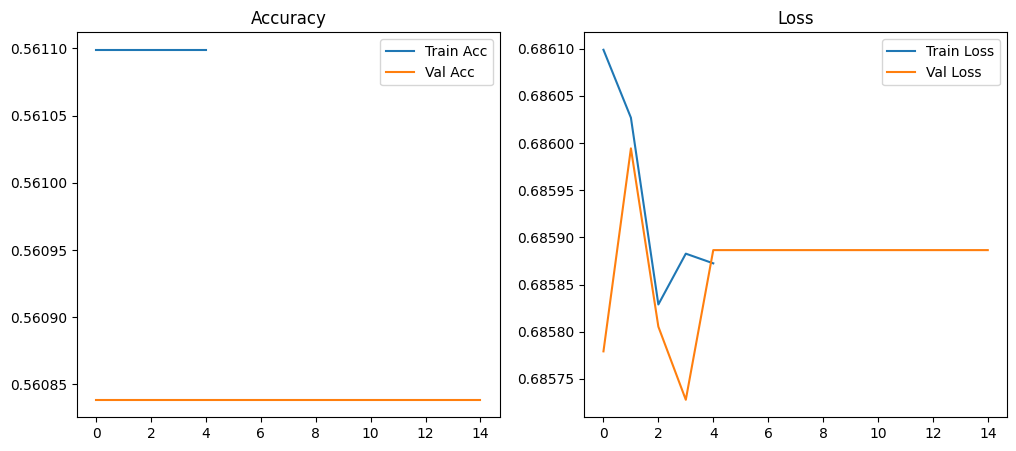

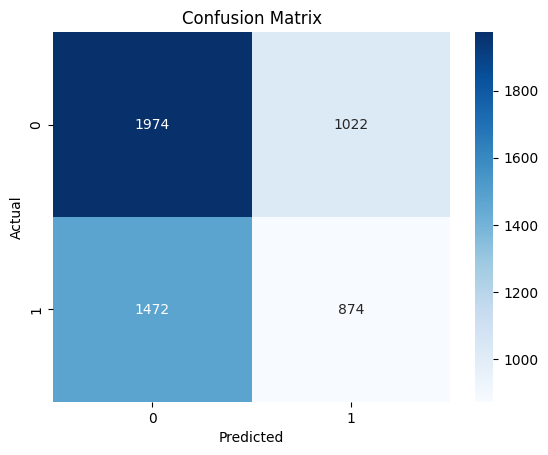

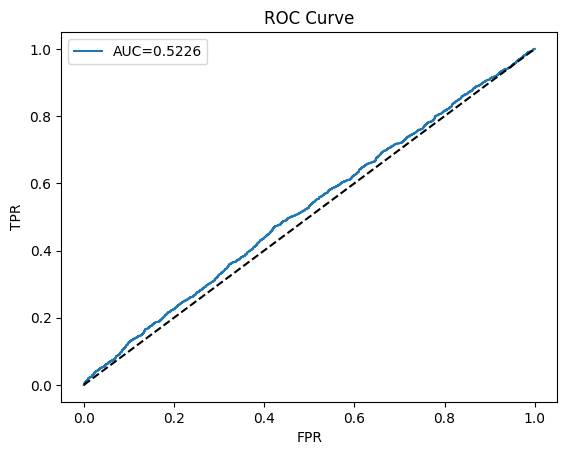

In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
        all_labels.extend(y_batch.numpy())

binary_preds = (np.array(all_preds) >= 0.5).astype(int)
accuracy = accuracy_score(all_labels, binary_preds)
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

print(f"\nRNN Final Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, binary_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()

#LSTM Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                            dropout=dropout, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        outputs, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(self.dropout(hidden)).squeeze(1)

model = LSTMModel(len(vocab), embedding_dim, hidden_dim, output_dim, n_layers, dropout).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)
        pred = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (pred == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = correct / total


    val_losses.append(val_loss / val_total)
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc={train_accs[-1]:.4f}, Val Acc={val_accs[-1]:.4f}")

Epoch 1: Train Acc=0.5611, Val Acc=0.5608
Epoch 2: Train Acc=0.5611, Val Acc=0.5608
Epoch 3: Train Acc=0.5611, Val Acc=0.5608
Epoch 4: Train Acc=0.5611, Val Acc=0.5608
Epoch 5: Train Acc=0.5611, Val Acc=0.5608
Epoch 6: Train Acc=0.5611, Val Acc=0.5608
Epoch 7: Train Acc=0.5611, Val Acc=0.5608
Epoch 8: Train Acc=0.5611, Val Acc=0.5608
Epoch 9: Train Acc=0.5611, Val Acc=0.5608
Epoch 10: Train Acc=0.5611, Val Acc=0.5608



LSTM Final Evaluation on Test Set:
Accuracy : 0.7782
Precision: 0.7505
Recall   : 0.7413
F1 Score : 0.7459
AUC      : 0.8587


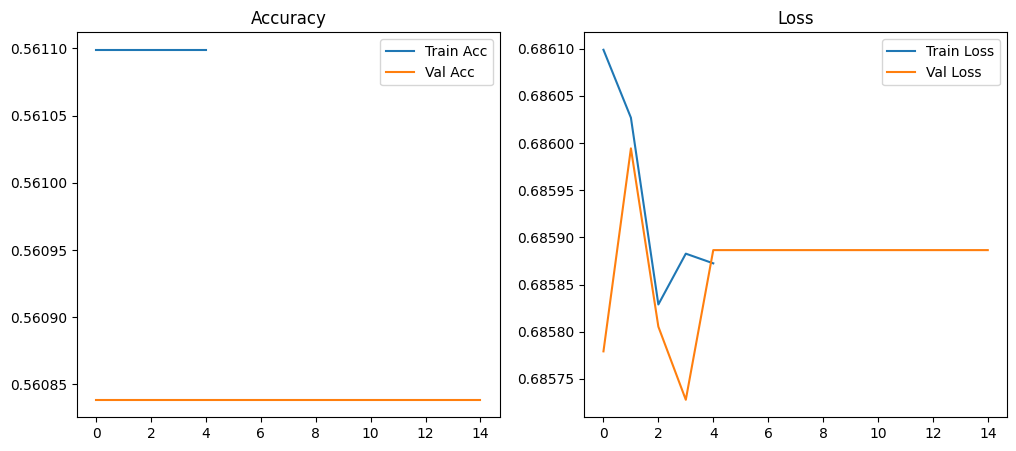

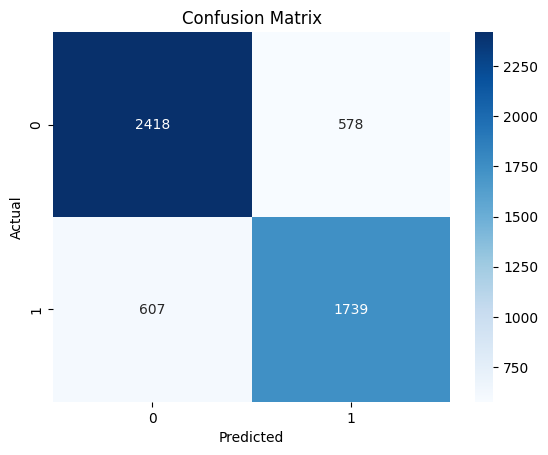

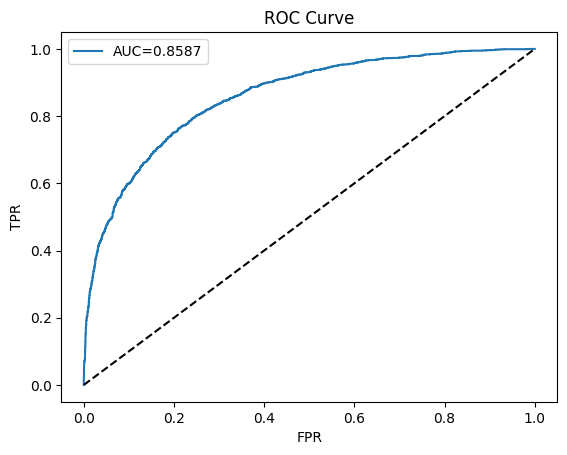

In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
        all_labels.extend(y_batch.numpy())

binary_preds = (np.array(all_preds) >= 0.5).astype(int)
accuracy = accuracy_score(all_labels, binary_preds)
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)


print(f"\nLSTM Final Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, binary_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()


#GRU Model

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, output_dim=1, n_layers=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers,
                          dropout=dropout, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(self.dropout(hidden_cat)).squeeze(1)

model = GRUModel(len(vocab), embedding_dim, hidden_dim, output_dim, n_layers, dropout).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
def train_model(model, train_loader, test_loader, epochs=10, lr=0.0005):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (torch.sigmoid(output) >= 0.5).float()
            total_correct += (preds == y_batch).sum().item()

        acc = total_correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f} - Accuracy: {acc:.4f}")


GRU Final Evaluation on Test Set:
Accuracy : 0.5331
Precision: 0.4610
Recall   : 0.3725
F1 Score : 0.4121
AUC      : 0.5226


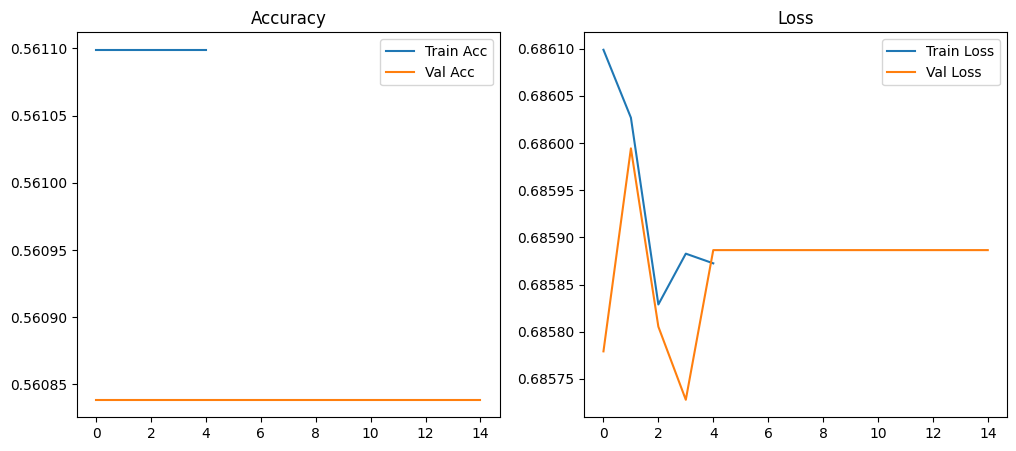

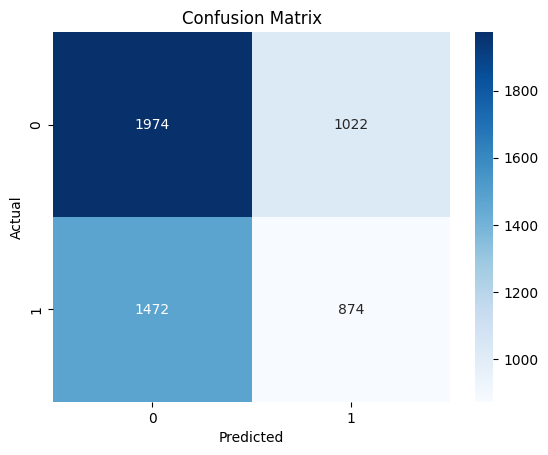

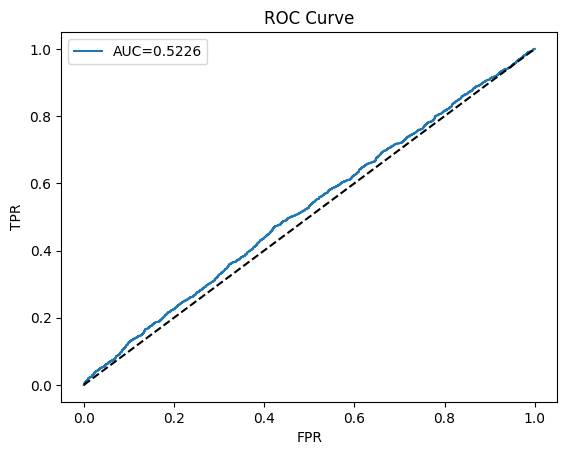

In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        all_preds.extend(torch.sigmoid(outputs).cpu().numpy())
        all_labels.extend(y_batch.numpy())

binary_preds = (np.array(all_preds) >= 0.5).astype(int)
accuracy = accuracy_score(all_labels, binary_preds)
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
auc = roc_auc_score(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)


print(f"\nGRU Final Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, binary_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()








# Penjelasan Model, Visualisasi, dan Metrik

---

## 1. RNN (Recurrent Neural Network)

### Persamaan Dasar:

$$
h_t = \phi(W_{hh}h_{t-1} + W_{xh}x_t + b_h)
$$

**Keterangan:**
- \( h_t \): State tersembunyi pada waktu ke-\(t\)
- \( x_t \): Input pada waktu ke-\(t\)
- \( W_{xh}, W_{hh} \): Matriks bobot
- \( b_h \): Bias
- \( \phi \): Fungsi aktivasi (tanh atau ReLU)

---

## 2. LSTM (Long Short-Term Memory)

LSTM menggunakan tiga gerbang untuk mengatur aliran informasi.

### Persamaan:

**Forget Gate:**

$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

**Input Gate:**

$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$

$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

**Cell State Update:**

$$
C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
$$

**Output Gate:**

$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$

$$
h_t = o_t \cdot \tanh(C_t)
$$

---

## 3. GRU (Gated Recurrent Unit)

GRU menyederhanakan LSTM dengan hanya dua gerbang.

### Persamaan:

**Reset Gate:**

$$
r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
$$

**Update Gate:**

$$
z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
$$

**State Update:**

$$
\tilde{h}_t = \tanh(W_h \cdot [r_t * h_{t-1}, x_t] + b_h)
$$

$$
h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t
$$

---


# Analisis Perbandingan Nilai Model

## Tabel Evaluasi Akhir

| Metrik     | RNN      | LSTM     | GRU      |
|------------|----------|----------|----------|
| Accuracy   | 0.5331   | 0.7782   | 0.5331   |
| Precision  | 0.4610   | 0.7505   | 0.4610   |
| Recall     | 0.3725   | 0.7413   | 0.3725   |
| F1 Score   | 0.4121   | 0.7459   | 0.4121   |
| AUC        | 0.5226   | 0.8587   | 0.5226   |

---

## Analisis Setiap Metrik

### 1. Accuracy

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

- **RNN & GRU:** 53.31% — performa kurang baik, kemungkinan model belum mampu menangkap pola data dengan baik.
- **LSTM:** 77.82% — sangat baik dalam mengenali pola dan membuat prediksi yang akurat.

---

### 2. Precision

$$
Precision = \frac{TP}{TP + FP}
$$

- **RNN & GRU:** 46.10% — banyak prediksi positif yang salah.
- **LSTM:** 75.05% — sebagian besar prediksi positif yang diambil benar.

---

### 3. Recall

$$
Recall = \frac{TP}{TP + FN}
$$

- **RNN & GRU:** 37.25% — tidak berhasil mendeteksi sebagian besar data positif.
- **LSTM:** 74.13% — mampu mendeteksi sebagian besar contoh kelas positif.

---

### 4. F1 Score

$$
F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
$$

- **RNN & GRU:** 41.21% — keseimbangan precision dan recall yang masih rendah.
- **LSTM:** 74.59% — keseimbangan yang sangat baik antara precision dan recall.

---

### 5. AUC (Area Under Curve)

- **RNN & GRU:** 0.5226 — hampir seperti tebakan acak, kurang mampu membedakan antara kelas.
- **LSTM:** 0.8587 — sangat baik dalam membedakan antara kelas positif dan negatif.

---

## Kesimpulan

- **LSTM** secara konsisten menunjukkan performa yang unggul dibanding **RNN** dan **GRU**, baik dari sisi akurasi maupun generalisasi.
- **GRU** memiliki performa yang identik dengan RNN dalam eksperimen ini, menandakan bahwa konfigurasi atau pelatihan model GRU belum optimal.
- Kelebihan **LSTM** terletak pada mekanisme gate yang lebih lengkap (forget, input, output gate) yang membantu mempertahankan informasi penting dalam urutan panjang.
- Sementara **GRU** secara teori lebih efisien daripada LSTM, pada praktik ini belum menunjukkan hasil yang kompetitif.
- Untuk masalah klasifikasi berbasis teks, **LSTM** adalah pilihan yang lebih stabil dan akurat di antara ketiganya.



## Penjelasan Matematika PyTorch

### nn.Embedding

Mengubah indeks kata menjadi vektor embedding.

- Input: `(batch_size, sequence_length)`
- Output: `(batch_size, sequence_length, embedding_dim)`

### nn.RNN

$$
h_t = \tanh(W_{ih}x_t + W_{hh}h_{t-1} + b)
$$

### nn.GRU

PyTorch mengatur secara otomatis:
- Reset gate: \( r_t \)
- Update gate: \( z_t \)
- New memory: \( \tilde{h}_t \)
- Hidden state: \( h_t \)

### nn.LSTM

PyTorch mengelola:
- Cell state: \( C_t \)
- Hidden state: \( h_t \)
- Forget, input, dan output gate

### Dropout (nn.Dropout)

$$
y = x * \text{mask} \quad \text{(mask = 0 atau 1 dengan probabilitas p)}
$$

### Linear Layer (nn.Linear)

$$
y = Wx + b
$$

### Binary Cross Entropy Loss (BCELoss)

$$
L = -[y \log(p) + (1 - y) \log(1 - p)]
$$

### GradScaler (torch.amp)

- Forward pass: float16
- Backward pass: gradien diskalakan untuk menjaga kestabilan pelatihan

### ReduceLROnPlateau

```python
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)
scheduler.step(val_loss)

